In [31]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial import distance
from OpenMiChroM.CndbTools import cndbTools
from scipy.cluster import hierarchy 
cndbT=cndbTools()

In [60]:

def calc_prob(data, mu, rc):
    return 0.5 * (1.0 + np.tanh(mu * (rc - distance.cdist(data, data, 'euclidean'))))

def compute_HiC(traj, mu=3.22, rc=1.78):
    
    pol_size=traj.shape[1]
    
    Prob = np.zeros((pol_size, pol_size))
    
    for ii, snapshot in enumerate(traj):
        Prob += calc_prob(snapshot, mu, rc)
        if ii % 2000 == 0:
            print("Reading frame {:} of {:}\n".format(ii, len(traj)))

    Prob=Prob/(ii+1)

    return Prob

def get_clusters_from_snap(snapshot, d_cutoff):
    Z = hierarchy.linkage(snapshot,method='centroid')
    clusters = hierarchy.fcluster(Z, d_cutoff, criterion='distance')
    return Z, clusters

def compute_num_clusters(xyz, d_cutoff=8.0):
    print(f'Using d_cutoff {d_cutoff}\n')
    cluster_number = []
    if len(xyz.shape)==3:
        for snapshot in xyz:
            Z, clusters = get_clusters_from_snap(snapshot, d_cutoff)
            cluster_number.append(len(np.unique(clusters)))
    
    elif len(xyz.shape)==2:
        Z, clusters = get_clusters_from_snap(xyz, d_cutoff)
        cluster_number.append(len(np.unique(clusters)))

    return [np.mean(cluster_number), np.std(cluster_number)]

def load_traj(traj_file, types='None', Nframes=10, dn=2):
    print('Loading trajectory ...')
    trajec = cndbT.load(traj_file) 
    assert trajec.Nframes>Nframes, "Nframes is larger than bounds"
    
    if types=='None':
        xyz = trajec.xyz(frames=[1,Nframes,dn])
    else:
        assert types in trajec.dictChromSeq.keys(), f"types in not a valid type. Valid types are {trajec.dictChromSeq.keys()}"
        xyz = trajec.xyz(frames=[1,Nframes,dn], beadSelection=trajec.dictChromSeq[types])
    print('Trajectory shape:', xyz.shape)
    return xyz
        

def divide_into_subtraj(xyz, num_proc):
    sub_frames=xyz.shape[0]//num_proc
    inputs=[xyz[ii*sub_frames:(ii+1)*sub_frames,:,:] for ii in range(num_proc)]
    return inputs

def compute_fn_parallel(xyz, func):
    num_proc = multiprocessing.cpu_count()

    if xyz.shape[0]<=num_proc: num_proc = 1

    subtraj_list = divide_into_subtraj(xyz, num_proc)
    print("Dividing into {} processes".format(num_proc))
    pool = multiprocessing.Pool(processes=num_proc)
    res = pool.map(func, subtraj_list)

    res = np.array(res)
    assert res.shape[0]==num_proc, f'something is off!! dimension of the result is {res.shape}.'
    res = np.mean(res,axis=0)
    return res

    

In [54]:
#load from cndb file
traj_file = "/scratch/sb95/loop_extrusion/k_off0.001_nLE100/replica_1/traj_chr10_LE_0.cndb"
xyzA = load_traj(traj_file, Nframes=100, types='A')
# xyzB = load_traj(traj_file, Nframes=10, types='B')
# xyz = load_traj(traj_file, Nframes=50)


Loading trajectory ...
Trajectory shape: (50, 1081, 3)


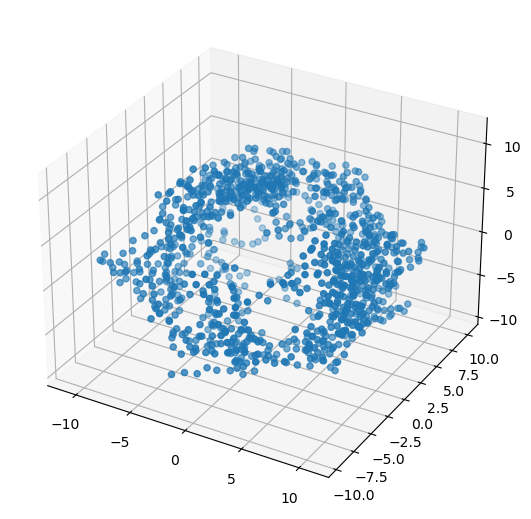

In [53]:
#visualize a snapshot
fig = plt.figure(figsize=(5,5))
ax = fig.add_axes([0,0,1,1],projection='3d')

ax.scatter(xyzA[2,:,0], xyzA[2,:,1], xyzA[2,:,2])
# ax.plot(xyzB[0,:,0], xyzB[0,:,1], xyzB[0,:,2],'ro')

In [13]:
#construct the linkage matrix and clusters for the A monomers in a specific snapshot using a distance cutoff 10.0
d = 8.0
ZA, clustersA = get_clusters_from_snap(snapshot=xyzA[2], d_cutoff=d)

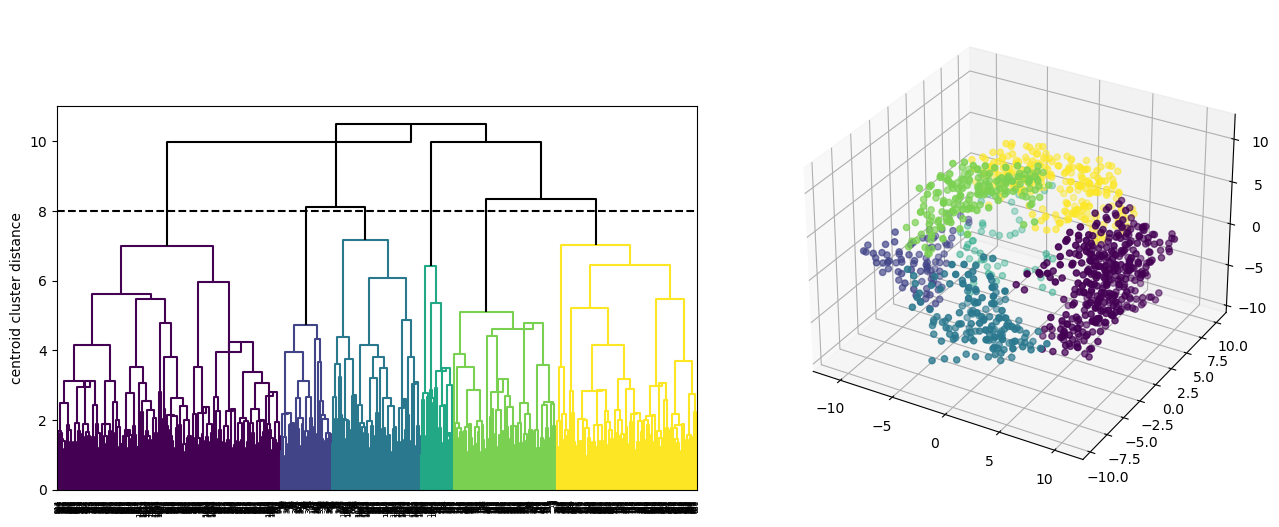

In [51]:

fig = plt.figure()
ax1 = fig.add_axes([0,0,1,0.8])
ax2 = fig.add_axes([1,0,1,1],projection='3d')

#trick to control the color scheme below threshold in dendrogram
nclusters = len(np.unique(clustersA))
viridis = mpl.colormaps['viridis'].resampled(nclusters)
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(viridis(xx)) for xx in np.linspace(0,1,nclusters)])

#plot the dendrogram
hierarchy.dendrogram(ZA, ax=ax1, above_threshold_color='k')
#plot the threshold
# the number of time the horizontal line crosses the dendrogram is the number of clusters
ax1.axhline(d, c='k', ls='--')
ax1.set_ylabel('centroid cluster distance')

#plot the clusters in 3D space to find the right cutoff
ax2.scatter(xyzA[2,:,0], xyzA[2,:,1], xyzA[2,:,2],'o', c=clustersA, cmap='viridis')


In [61]:
#now compute for a trajectory using parallel processing
#note it can be alittle tricky to pass multiple arguments to parallel processing
# adjust default d_cutoff to desired value in compute_num_clusters before running parallelly
n_clust, n_std = compute_fn_parallel(xyzA, compute_num_clusters)

print(f'Number of clusters: {n_clust} +/- {n_std}')

Dividing into 8 processes
Using d_cutoff 8.0

Using d_cutoff 8.0
Using d_cutoff 8.0

Using d_cutoff 8.0


Using d_cutoff 8.0
Using d_cutoff 8.0


Using d_cutoff 8.0
Using d_cutoff 8.0


Number of clusters: 6.583333333333333 +/- 0.6568010302313155
